### Three_poet_benchmark

The purpose of this file is to test my matching algorithm in the simple setting of three distinct poets

We'll scour the poetry data from "poemhunter.com" to see what's in there.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import string
from sklearn.pipeline import Pipeline
from textblob import TextBlob
import re
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
import itertools
from contractions import contractions_dict
from sklearn.metrics import confusion_matrix
import spacy
from sklearn.base import TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
import poeml_utility as pml # this is my own utility file

In [6]:
# path and file names for both full poetry set and also cleaned set
datapath = "/Users/ctoews/Documents/Insight/Project/data/poems/csv/"
#filename = "final_df.csv"
filename2 = "poemhunter_clean.csv"

In [7]:
#  store the poetry as a datafame
poetry = pd.read_csv(datapath+filename2)

In [8]:
# calculate length for each poem, for commensurability
poetry['lengths'] = poetry['full_poem'].map(lambda x: len(x))

In [9]:
# grab just the poems from these three poets
poets = ['Emily Dickinson','Robert Frost', 'Wallace Stevens']
df = poetry.loc[poetry.name.isin(poets),:]
print(df.name.drop_duplicates())
len(df)

334      Emily Dickinson
22227    Wallace Stevens
24100       Robert Frost
Name: name, dtype: object


1992

In [514]:
#df.to_sql('poetry_poems',engine)

In [10]:
grouped = df.groupby('name')
x = grouped.median()

In [11]:
min_lengths = np.min(x.lengths)
length_factors = np.ceil(x.lengths/min_lengths)
length_factors

name
Emily Dickinson    1.0
Robert Frost       3.0
Wallace Stevens    4.0
Name: lengths, dtype: float64

Split the verse into sentences.

In [12]:
def split_by_sentence(str_series):
    '''input is a series whose elements are strings'''
    str_series=str_series.str.split(r'[.?!]')
    #str_series=str_series.apply(pd.Series).stack().reset_index(level=1, drop=True)
    return str_series

In [13]:
df.full_poem[0:5]

334    Today or this noon She dwelt so close I almost...
335    A Mien to move a Queen -- Half Child -- Half H...
336    A Sparrow took a Slice of Twig And thought it ...
337    "Go tell it" -- What a Message -- To whom -- i...
338    Be Mine the Doom -- Sufficient Fame -- To peri...
Name: full_poem, dtype: object

In [14]:
#df.full_poem = split_by_sentence(df.full_poem)

In [15]:
res = df.set_index(['name', 'number','birth','death','lengths'])['full_poem'].apply(pd.Series).stack()
res = res.reset_index()
res.columns = ['name', 'number','birth','death','lengths','sentence_num','full_poem']
df = res
len(df)

1992

In [16]:
df = df.loc[df.full_poem!='',:]
df.head()

name  number  birth  death  lengths  sentence_num  \
0  Emily Dickinson    1779   1830   1886      137             0   
1  Emily Dickinson    1779   1830   1886      554             0   
2  Emily Dickinson    1779   1830   1886      204             0   
3  Emily Dickinson    1779   1830   1886      239             0   
4  Emily Dickinson    1779   1830   1886       61             0   

                                           full_poem  
0  Today or this noon She dwelt so close I almost...  
1  A Mien to move a Queen -- Half Child -- Half H...  
2  A Sparrow took a Slice of Twig And thought it ...  
3  "Go tell it" -- What a Message -- To whom -- i...  
4  Be Mine the Doom -- Sufficient Fame -- To peri...

Clean up the text for analysis:  strip punctuation, convert to lowercase, and eliminate numbers.

In [17]:
df.full_poem = df['full_poem'].str.replace('[{}]'.format(string.punctuation), '')
df.full_poem = df['full_poem'].str.replace('[{}]'.format(string.digits), '')
for contraction, expansion in contractions_dict.items():
    df.full_poem = df['full_poem'].str.replace(contraction.lower(),expansion.lower())

In [18]:
grouped = df.groupby('name')
grouped.median()

number  birth  death  lengths  sentence_num
name                                                        
Emily Dickinson    1779   1830   1886      239             0
Robert Frost        180   1874   1963      681             0
Wallace Stevens      33   1879   1955      721             0

In [19]:
180/((721/681)*33)
1779/((721/239)*33)


17.870003782625144

In [20]:
# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [21]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # import a dictionary of English contractions from another file
    from contractions import contractions_dict
    
    # replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction.lower(),expansion.lower())
    
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ").replace("-"," ").replace("\'st"," ")
    
    # lowercase
    text = text.lower()

    return text

In [22]:
# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() 
                      if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
#    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    
    return tokens

### Modeling

In order to fit the data, we'll pare it down to have roughly even numbers in each category

In [23]:
grouped = df.groupby('name')
counts = grouped.apply(lambda x: len(x))
min_count = np.min(x) # minimum number of poems
step = np.ceil(counts/min_count)

In [24]:
int(step[0])

ValueError: cannot convert float NaN to integer

In [25]:
#df_1 = df[df.name =='Emily Dickinson'][::53]
#df_2 = df[df.name=='Robert Frost'][::5]
#df_3 = df[df.name=='Wallace Stevens'][::1]

df_1 = df[df.name =='Emily Dickinson'][::50]
df_2 = df[df.name=='Robert Frost'][::7]
df_3 = df[df.name=='Wallace Stevens'][::2]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)


(36, 7)
(26, 7)
(17, 7)


In [26]:
df_model = pd.concat([df_1, df_2, df_3], axis=0)
df_model.reset_index(inplace=True, drop=True)
df_model.to_csv('three_poets_df.csv')
df_model.head()
df_model.shape

(79, 7)

In [27]:
X = df_model.full_poem
y = df_model.name

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [29]:
#cvt = CountVectorizer(stop_words='english')
cvt = TfidfVectorizer(stop_words='english')
parser = spacy.load('en')

In [30]:
X_train = pd.DataFrame(cvt.fit_transform(X_train).todense(), columns=cvt.get_feature_names())
X_test = pd.DataFrame(cvt.transform(X_test).todense(), columns=cvt.get_feature_names())
X_train.rename(columns={'fit':'fit_feature'}, inplace=True);
X_test.rename(columns={'fit':'fit_feature'}, inplace=True);

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55, 2521)
(55,)
(24, 2521)
(24,)


In [32]:
nb = MultinomialNB(alpha=0.3)
nb.fit(X_train, y_train)
preds = nb.predict(X_test)
nb.score(X_test, y_test)

0.6666666666666666

In [33]:
cross_val_score(nb, X_train, y_train, cv=10).mean()

0.7152380952380952

In [34]:
nb.feature_log_prob_.shape

(3, 2521)

In [35]:
log_prob = pd.DataFrame(nb.feature_log_prob_, columns=X_train.columns, index=['Emily', 'Robert', 'Wallace'])
prob = np.exp(log_prob)
log_prob

abandon  abasheth  abdication     abide     abode    abroad  \
Emily   -7.965288 -7.457105   -7.294205 -7.381861 -7.135047 -7.965288   
Robert  -7.642054 -8.015771   -8.015771 -8.015771 -8.015771 -7.616455   
Wallace -7.934072 -7.934072   -7.934072 -7.934072 -7.934072 -7.934072   

         abruptly  absurdly     abyss  accepted    ...       youhis     youll  \
Emily   -7.965288 -7.965288 -7.207363 -7.965288    ...    -7.965288 -7.965288   
Robert  -7.831509 -7.963702 -8.015771 -7.914210    ...    -7.899375 -7.963702   
Wallace -7.934072 -7.934072 -7.934072 -7.934072    ...    -7.934072 -7.934072   

            young  youngsters     youre    zealot    zigzag       œiâ  \
Emily   -7.965288   -7.965288 -7.965288 -7.965288 -7.965288 -7.965288   
Robert  -7.659464   -7.874234 -7.795126 -7.963702 -7.963702 -7.914210   
Wallace -7.612765   -7.934072 -7.934072 -7.934072 -7.934072 -7.934072   

           œwhere      œwhy  
Emily   -7.965288 -7.965288  
Robert  -7.963702 -7.963702  
Wallace -7.934072 -7.934072  

[3 rows x 2521 columns]

In [36]:
Emily = prob.iloc[0].nlargest(11).to_frame().T
Robert = prob.iloc[1].nlargest(11).to_frame().T
Wallace = prob.iloc[2].nlargest(11).to_frame().T


In [37]:
common_words = pd.concat([Emily, Robert, Wallace])
common_words

air       cat      come    crawls      dont  emperor   flowers  \
Emily    0.000986       NaN       NaN       NaN       NaN      NaN       NaN   
Robert        NaN       NaN  0.001201       NaN  0.001118      NaN  0.001166   
Wallace       NaN  0.001013       NaN  0.000949       NaN  0.00096       NaN   

              god     grace     green    ...        stars       sun     tell  \
Emily    0.000983  0.001175       NaN    ...          NaN       NaN  0.00091   
Robert        NaN       NaN       NaN    ...     0.000986       NaN      NaN   
Wallace       NaN       NaN  0.001422    ...          NaN  0.001246      NaN   

             thee    things       tis  tremendous     twas   village      webs  
Emily    0.001193       NaN  0.001456     0.00096  0.00096       NaN       NaN  
Robert        NaN       NaN       NaN         NaN      NaN       NaN       NaN  
Wallace       NaN  0.000932       NaN         NaN      NaN  0.000953  0.000949  

[3 rows x 31 columns]

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9 4 0]
 [0 6 0]
 [1 3 1]]


TypeError: text() missing 3 required positional arguments: 'x', 'y', and 's'

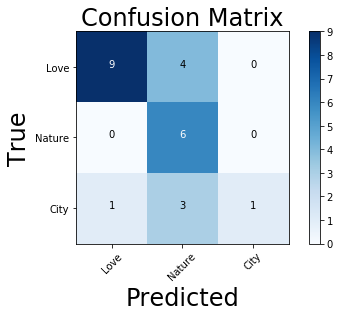

In [45]:
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Love', 'Nature', 'City'], normalize=False,
                      title='Normalized Confusion Matrix')
plt.xlabel('Predicted',fontsize=24)
plt.ylabel('True',fontsize=24)
plt.title('Confusion Matrix',fontsize=24)
plt.text(fontsize=24)
plt.show()

In [328]:
y_test.value_counts()

Emily Dickinson    12
Robert Frost       10
Wallace Stevens     9
Name: name, dtype: int64

In [366]:
print(classification_report(y_test, preds))

                 precision    recall  f1-score   support

Emily Dickinson       1.00      0.50      0.67        12
   Robert Frost       0.48      1.00      0.65        10
Wallace Stevens       0.75      0.33      0.46         9

    avg / total       0.76      0.61      0.60        31



In [367]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5161290322580645

In [368]:
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm.score(X_test, y_test)

0.6451612903225806

In [369]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.5806451612903226

In [370]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5806451612903226

### Now do the fitting in the embedded vector space

Two approaches here:  one is to use topic modeling followed by vector space embedding, the other is to use straight word to vec.  I'll implement both.

**Approach 1:  topic-to-embedding**

In [466]:
# define the number features, topics, and how many 
# words/documents to display later on
n_features      = 1000
n_topics        = 5
n_top_words     = 5
n_top_documents = 5

# Use tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=n_features,
                             tokenizer=tokenizeText,
                             stop_words='english')
#vectorizer = CountVectorizer(max_features=n_features,
#                             tokenizer=tokenizeText,
#                             stop_words='english')

        
# use NMF model with the Frobenius norm
nmf = NMF(n_components=n_topics, random_state=1, 
          solver='mu', beta_loss='frobenius')

# use NMF model with the Frobenius norm
#nmf = NMF(n_components=n_topics, random_state=1)

# put it all in a pipeline
pipe = Pipeline([('cleanText', CleanTextTransformer()), 
                 ('vectorizer', vectorizer), ('nmf', nmf)])

In [467]:
# grab term-document matrix
data = df.full_poem
transform = pipe.fit_transform(data)

In [468]:
def display_topics(vectorizer, nmf, W, df, n_top_words, n_top_documents):
    ''' Print out topics discovered by a model '''
    
    feature_names = vectorizer.get_feature_names()
    
    for topic_id, topic in enumerate(nmf.components_):
        print('Topic #%02d: %s ' % (topic_id+1, ' '.join([str(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]])))
        
        top_doc_indices = np.argsort( W[:,topic_id] )[::-1][0:n_top_documents]
        avg_polarity = 0
        for doc_index in top_doc_indices:
            doc = TextBlob(data.iloc[doc_index])
            avg_polarity += doc.sentiment[0]
            print('Line: {} (with polarity {}) \n'.format(data.iloc[doc_index], 
                                     doc.sentiment[0]))
            #print(df['reviewText'].iloc[doc_index]+"\n")
        print("Average polarity: %4.2f" % (avg_polarity / n_top_documents))
        print()
        

display_topics(vectorizer, nmf, transform, data, n_top_words, n_top_documents)

Topic #01: like come say know make 
Line: Mary sat musing on the lampflame at the table Waiting for Warren When she heard his step She ran on tiptoe down the darkened passage To meet him in the doorway with the news And put him on his guard Silas is back She pushed him outward with her through the door And shut it after her Be kind she said She took the market things from Warrens arms And set them on the porch then drew him down To sit beside her on the wooden steps When was I ever anything but kind to him But Ill not have the fellow back he said I told him so last haying didnt I If he left then I said that ended it What good is he Who else will harbour him At his age for the little he can do What help he is theres no depending on Off he goes always when I need him most He thinks he ought to earn a little pay Enough at least to buy tobacco with wont have to beg and be beholden All right I say I cant afford to pay Any fixed wages though I wish I could Someone else can Then someone else 

**Method 2:** straight word2vec

In [509]:
df

name                                          full_poem  \
334    Emily Dickinson  today or this noon she dwelt so close i almost...   
335    Emily Dickinson  a mien to move a queen  half child  half heroi...   
336    Emily Dickinson  a sparrow took a slice of twig and thought it ...   
337    Emily Dickinson  go tell it  what a message  to whom  is specif...   
338    Emily Dickinson  be mine the doom  sufficient fame  to perish i...   
339    Emily Dickinson  tis good  the looking back on grief  to reendu...   
340    Emily Dickinson  parting with thee reluctantly that we have nev...   
341    Emily Dickinson  dear march  come in  how glad i am  i hoped fo...   
342    Emily Dickinson  going to him  happy letter tell him  tell him ...   
343    Emily Dickinson  death sets a thing significant the eye had hur...   
344    Emily Dickinson  a tooth upon our peace the peace cannot deface...   
345    Emily Dickinson  twas sorry that we were  for where the holiday...   
346    Emily Dickinson  a pang is more conspicuous in spring in contra...   
347    Emily Dickinson  least bee that brew  a honeys weight content h...   
348    Emily Dickinson  your thoughts dont have words every day they c...   
349    Emily Dickinson  this docile one inter while we who dare to liv...   
350    Emily Dickinson  nature  the gentlest mother is impatient of no...   
351    Emily Dickinson  i years had been from home and now before the ...   
352    Emily Dickinson  no rack can torture me  my soul  at liberty  b...   
353    Emily Dickinson  a narrow fellow in the grass occasionally ride...   
354    Emily Dickinson  the rose did caper on her cheek  her bodice ro...   
355    Emily Dickinson  that odd old man is dead a year  we miss his s...   
356    Emily Dickinson  i know lives i could miss without a misery  ot...   
357    Emily Dickinson  conferring with myself my stranger disappeared...   
358    Emily Dickinson  well pass without the parting so to spare cert...   
359    Emily Dickinson  to tell the beauty would decrease to state the...   
360    Emily Dickinson  dont put up my thread and needle  ill begin to...   
361    Emily Dickinson  i tie my hat  i crease my shawl  lifes little ...   
362    Emily Dickinson  what did they do since i saw them were they in...   
363    Emily Dickinson  removed from accident of loss by accident of g...   
...                ...                                                ...   
24250     Robert Frost  in going from room to room in the dark i reach...   
24251     Robert Frost  when the spent sun throws up its rays on cloud...   
24252     Robert Frost  you come to fetch me from my work tonight when...   
24253     Robert Frost  as i went down the hill along the wall there w...   
24254     Robert Frost  it is bluebutterfly day here in spring and wit...   
24255     Robert Frost  to think to know the country and now know the ...   
24256     Robert Frost  it snowed in spring on earth so dry and warm t...   
24257     Robert Frost  builder in building the little house in every ...   
24258     Robert Frost  a plow they say to plow the snow they cannot m...   
24259     Robert Frost  here come the linegang pioneering by they thro...   
24260     Robert Frost  love and forgetting might have carried them a ...   
24261     Robert Frost  by june our brooks run out of song and speed s...   
24262     Robert Frost  ive known ere now an interfering branch of ald...   
24263     Robert Frost  out of the mud two strangers came and caught m...   
24264     Robert Frost  as told to a child   as i went out a crow in a...   
24265     Robert Frost  when i spread out my hand here today i catch n...   
24266     Robert Frost  these pools that though in forests still refle...   
24267     Robert Frost  snow falling and night falling fast oh fast in...   
24268     Robert Frost  where had i heard this wind before change like...   
24269     Robert Frost  there overtook me and drew me in to his downhi...   
24270     Robe

In [475]:
df.full_poem = clean_text(data)
df.head()

name                                          full_poem  \
334  Emily Dickinson  today or this noon she dwelt so close i almost...   
335  Emily Dickinson  a mien to move a queen  half child  half heroi...   
336  Emily Dickinson  a sparrow took a slice of twig and thought it ...   
337  Emily Dickinson  go tell it  what a message  to whom  is specif...   
338  Emily Dickinson  be mine the doom  sufficient fame  to perish i...   

     number  birth  death  lengths  
334    1779   1830   1886      137  
335    1779   1830   1886      554  
336    1779   1830   1886      204  
337    1779   1830   1886      239  
338    1779   1830   1886       61

In [494]:
parsed_poems = []
t = list(data)
for poem in t:
    parsed_poems.append(parser(poem))
    

In [501]:
all_vecs = np.zeros((1992,384))
for i in np.arange(1992):
    all_vecs[i,:]=parsed_poems[i].vector
all_vecs.shape    

(1992, 384)

In [503]:
poem_df = pd.DataFrame(all_vecs)
poem_df

0         1         2         3         4         5         6    \
0     0.169214 -0.043931  0.288853  0.204585  0.939024 -0.240376 -0.355544   
1     0.411833  0.490949  0.596793  1.366122  0.160941 -0.249321 -1.527615   
2     0.142718 -0.224949 -0.044763  1.395626  0.401942 -0.732893 -0.650973   
3    -0.080754  0.457643  0.880855  1.014449  0.072870 -0.046742 -1.590813   
4     0.128323  0.490038  1.300968  1.654804 -0.952023  1.044904 -1.292389   
5     0.480434  0.443883  0.994192  1.107863  0.239272 -0.081900 -1.126422   
6     0.228383  0.029395  0.269615  1.114779  1.538654 -1.270449 -0.940378   
7    -0.165067 -0.100182  0.833913  0.602966  0.501497 -0.471304 -0.845329   
8    -0.445276 -0.026586  1.042823  0.504752  0.172514  0.024053 -0.676237   
9     0.228387  0.284673  0.840084  0.937003  0.403426 -0.325257 -1.059820   
10    0.421888  0.906507  0.913841  1.602458  0.372117 -0.318653 -0.850590   
11    0.136502  0.098847  0.316216  0.871796  0.432809 -0.281663 -0.869029   
12   -0.005167  0.044858  0.413227  0.695648  0.521520 -0.559588 -1.279459   
13    0.320257  0.432867  0.900512  1.124075 -0.113111  1.181174 -1.543527   
14    0.371970  0.519622  0.302094  0.751322  0.194339 -0.521060 -1.132598   
15    0.580573 -0.217154  0.471309  1.673740  0.330839 -0.429661 -1.055642   
16    0.276244  0.413654  0.631872  0.822783 -0.281413 -0.030978 -1.584413   
17    0.330388  0.052808  0.441442  0.994475  0.900215 -0.346488 -0.825426   
18    0.188008  0.618539  0.936885  1.297559  0.183893 -0.144281 -1.568908   
19    0.423727  0.102361  0.265045  1.420864  0.527737 -0.437342 -0.708704   
20   -0.037967  0.209127  0.736825  0.822978 -0.159344  0.023363 -1.024974   
21   -0.324833 -0.050907  0.626594  0.856481  0.553034  0.260685 -1.304872   
22   -0.171229  0.648384  1.557649  1.212148 -0.484034  0.002372 -1.696219   
23    0.047948  0.094907 -0.063199  0.983411  0.415636 -0.493874 -1.068039   
24    0.535630 -0.279608  1.180011  0.976519  0.867231 -0.482717 -0.908629   
25    0.350186  1.311449  0.102091  1.728763 -0.285697 -0.033520 -1.566203   
26   -0.004809  0.536649  0.974860  0.797397 -0.015224 -0.087015 -1.468255   
27   -0.040011  0.496147  0.983218  0.957647  0.055330 -0.092954 -1.448235   
28    0.429718  0.133007  0.694298  0.950424  0.316437 -0.371152 -0.393929   
29    0.307545  0.361955  0.313101  0.797992  0.071054 -0.385229 -1.148141   
...        ...       ...       ...       ...       ...       ...       ...   
1962  0.882457  0.073470  0.135410  1.634591  0.224648 -0.198207 -0.573444   
1963  0.418534  0.176482  0.562941  1.281150  0.235447  0.006642 -0.739400   
1964  0.566352  0.050536  0.250334  1.091466  0.373819 -0.403212 -0.678478   
1965  0.035440 -0.376865  0.502221  0.870610  1.002644 -0.587872 -0.007619   
1966  0.751101  0.267674  0.109148  0.880215  0.236371 -0.578041 -1.384392   
1967  0.784257  0.102171  0.432262  1.636332  0.631069 -0.589871 -0.662652   
1968  0.705222 -0.011042  0.292093  1.034312  0.297404 -0.282576 -0.809516   
1969  0.445896  0.112625  0.430431  1.196963  0.399827 -0.303657 -0.661359   
1970  0.933796  0.513949  0.651505  1.268909 -0.231728  0.889663 -1.265834   
1971  0.653416 -0.193283  0.832600  1.584201  0.698833 -0.371413 -0.490043   
1972  0.404210 -0.370918  0.389560  1.161335  0.927688 -0.675292 -0.215362   
1973  0.605266  0.115740  0.336235  1.196204  0.533176 -0.741191 -0.761612   
1974  0.288458 -0.108835  0.448928  1.349602  0.637919 -0.467916 -0.363057   
1975  0.433499  0.233020  0.322538  1.454415  0.471398 -0.357760 -0.816616   
1976  0.542921  0.238445  0.336001  1.234431  0.203772  0.421250 -0.446462   
1977  0.601005  0.074902  0.134919  1.074993  0.750514 -0.621284 -0.583793   
1978  0.921327  0.126283  0.624718  0.467926  0.238744 -0.452656 -0.852047   
1979  0.288916  0.097045  0.161018  1.272229  0.252979 -0.436978 -0.997316   
1980  0.208852  0.021114  0.142067  1.283485  0.542778 -0.173527 -0.953457   
1981  0.512788  0.082107  0.39411

In [506]:
engine = pml.connect_db()
poem_df.to_sql('poem_vecs',engine)

In [508]:
len(df)

1992

### Helper functions

In [490]:
def parse_list_of_strings(string_list):
    parsed = []
    import spacy
    parser = spacy.load('en')
    for item in string_list:
        print(item)
        p = parser(string)
        parsed.append(p)
        
    return parsed

In [159]:
mystring = ['Dog eats. moon','pig smells baby']
parsed = parse_list_of_strings(mystring)

In [471]:
def clean_text(str_series):
    '''removes punctuation, digits, and capital letters from series object containing string'''
    import string
    str_series = str_series.apply(lambda x: x.lower())
    str_series = str_series.str.replace('[{}]'.format(string.punctuation), '')
    str_series = str_series.str.replace('[{}]'.format(string.digits), '')
    
    return str_series

In [203]:
x = pd.Series(mystring)
split_by_sentence(x)

0           Dog eats
0               moon
1    pig smells baby
dtype: object

In [189]:
y=x.str.split(r'[.?!]')

In [196]:
s = 

In [201]:
s

0           Dog eats
0               moon
1    pig smells baby
dtype: object

<bound method Series.reset_index of 0           Dog eats
0               moon
1    pig smells baby
dtype: object>

In [515]:
query = "select * from poetry_poems order by index;"
sonnet_sentences = pd.read_sql(query,engine)

In [516]:
sonnet_sentences[]

index             name  \
0       334  Emily Dickinson   
1       335  Emily Dickinson   
2       336  Emily Dickinson   
3       337  Emily Dickinson   
4       338  Emily Dickinson   
5       339  Emily Dickinson   
6       340  Emily Dickinson   
7       341  Emily Dickinson   
8       342  Emily Dickinson   
9       343  Emily Dickinson   
10      344  Emily Dickinson   
11      345  Emily Dickinson   
12      346  Emily Dickinson   
13      347  Emily Dickinson   
14      348  Emily Dickinson   
15      349  Emily Dickinson   
16      350  Emily Dickinson   
17      351  Emily Dickinson   
18      352  Emily Dickinson   
19      353  Emily Dickinson   
20      354  Emily Dickinson   
21      355  Emily Dickinson   
22      356  Emily Dickinson   
23      357  Emily Dickinson   
24      358  Emily Dickinson   
25      359  Emily Dickinson   
26      360  Emily Dickinson   
27      361  Emily Dickinson   
28      362  Emily Dickinson   
29      363  Emily Dickinson   
...     ...              ...   
1962  24250     Robert Frost   
1963  24251     Robert Frost   
1964  24252     Robert Frost   
1965  24253     Robert Frost   
1966  24254     Robert Frost   
1967  24255     Robert Frost   
1968  24256     Robert Frost   
1969  24257     Robert Frost   
1970  24258     Robert Frost   
1971  24259     Robert Frost   
1972  24260     Robert Frost   
1973  24261     Robert Frost   
1974  24262     Robert Frost   
1975  24263     Robert Frost   
1976  24264     Robert Frost   
1977  24265     Robert Frost   
1978  24266     Robert Frost   
1979  24267     Robert Frost   
1980  24268     Robert Frost   
1981  24269     Robert Frost   
1982  24270     Robert Frost   
1983  24271     Robert Frost   
1984  24272     Robert Frost   
1985  24273     Robert Frost   
1986  24274     Robert Frost   
1987  24275     Robert Frost   
1988  24276     Robert Frost   
1989  24277     Robert Frost   
1990  24278     Robert Frost   
1991  24279     Robert Frost   

                                              full_poem  number  birth  death  \
0     Today or this noon She dwelt so close I almost...    1779   1830   1886   
1     A Mien to move a Queen -- Half Child -- Half H...    1779   1830   1886   
2     A Sparrow took a Slice of Twig And thought it ...    1779   1830   1886   
3     "Go tell it" -- What a Message -- To whom -- i...    1779   1830   1886   
4     Be Mine the Doom -- Sufficient Fame -- To peri...    1779   1830   1886   
5     'Tis good -- the looking back on Grief -- To r...    1779   1830   1886   
6     Parting with Thee reluctantly, That we have ne...    1779   1830   1886   
7     Dear March -- Come in -- How glad I am -- I ho...    1779   1830   1886   
8     Going to Him!  Happy letter! Tell Him -- Tell ...    1779   1830   1886   
9     Death sets a Thing significant The Eye had hur...    1779   1830   1886   
10    A Tooth upon Our Peace The Peace cannot deface...    1779   1830   1886   
11    'Twas sorry, that we were -- For where the Hol...    1779   1830   1886   
12    A Pang is more conspicuous in Spring In contra...    1779   1830   1886   
13    Least Bee that brew -- A Honey's Weight Conten...    1779   1830   1886   
14    Your thoughts don't have words every day They ...    1779   1830   1886   
15    This docile one inter While we who dare to liv...    1779   1830   1886   
16    Nature -- the Gentlest Mother is, Impatient of...    1779   1830   1886   
17    I Years had been from Home And now before the ...    1779   1830   1886   
18    No Rack can torture me -- My Soul -- at Libert...    1779   1830   1886   
19    A narrow Fellow in the Grass Occasionally ride...    1779   1830   1886   
20    The Rose did caper on her cheek -- Her Bodice ...    1779   1830   1886   
21    That odd old man is dead a year -- We miss his...    1779   1830   1886   
22    I know lives, I could miss Without a Misery --...    1779   1830   1886   
23    Conferring with myself My stranger disappeared...    1779   1830   1886